In [26]:
import pandas as pd

df = pd.read_csv("/Users/aayush/Desktop/Data Science/Projects/Geopolitical Risk Calc/Africa_Data.csv")


df.columns


Index(['WEEK', 'REGION', 'COUNTRY', 'ADMIN1', 'EVENT_TYPE', 'SUB_EVENT_TYPE',
       'EVENTS', 'FATALITIES', 'POPULATION_EXPOSURE', 'DISORDER_TYPE', 'ID',
       'CENTROID_LATITUDE', 'CENTROID_LONGITUDE'],
      dtype='object')

In [27]:
df.columns = df.columns.str.lower()

df = df.sort_values(['country', 'week'])

df['events_last_week'] = df['events']
df['fatalities_last_week'] = df['fatalities']

df['protests_last_week'] = (df['event_type'] == 'Protests').astype(int)

df['battles_last_week'] = (df['event_type'] == 'Battles').astype(int)

df['events_4wk_avg'] = (
    df.groupby('country')['events_last_week']
      .rolling(4)
      .mean()
      .reset_index(0, drop=True)
)


df.fillna(0, inplace=True)

print(df.head())


               week           region  country       admin1  \
1034  01-April-2000  Northern Africa  Algeria        Alger   
160   01-April-2006  Northern Africa  Algeria    Ain Defla   
6795  01-April-2006  Northern Africa  Algeria       Skikda   
7144  01-April-2006  Northern Africa  Algeria  Tamanrasset   
40    01-April-2017  Northern Africa  Algeria        Adrar   

                      event_type    sub_event_type  events  fatalities  \
1034  Violence against civilians            Attack       1          20   
160                      Battles       Armed clash       1           1   
6795                     Battles       Armed clash       1           1   
7144                     Battles       Armed clash       1          14   
40                      Protests  Peaceful protest       1           0   

      population_exposure       disorder_type    id  centroid_latitude  \
1034                  0.0  Political violence  50.0            36.7019   
160                   0.0  Politic

In [28]:
# Make column names lowercase (recommended)
df.columns = df.columns.str.lower()

# Now the columns are: week, region, country, event_type, events, fatalities, etc.

# Sort by country and week
df = df.sort_values(['country', 'week'])

# Protest flag THIS WEEK
df['had_protest_this_week'] = (df['event_type'] == 'Protests').astype(int)

# Label = protest NEXT WEEK
df['label_protest_next_week'] = (
    df.groupby('country')['had_protest_this_week']
      .shift(-1)
)

# Drop weeks with no "next week" label
df = df.dropna(subset=['label_protest_next_week'])

# Convert to int
df['label_protest_next_week'] = df['label_protest_next_week'].astype(int)

df[['country', 'week', 'had_protest_this_week', 'label_protest_next_week']].head()


,country,week,had_protest_this_week,label_protest_next_week
1034,Algeria,01-April-2000,0,0
160,Algeria,01-April-2006,0,0
6795,Algeria,01-April-2006,0,0
7144,Algeria,01-April-2006,0,1
40,Algeria,01-April-2017,1,1


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

features = df[['events', 'fatalities', 'had_protest_this_week']]
X = features
y = df['label_protest_next_week']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

df_test = X_test.copy()
df_test['true_label'] = y_test
df_test['predicted_label'] = y_pred
df_test['risk_score'] = y_prob

print(df_test.head())

Accuracy: 0.734924647357351
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     39556
           1       0.44      0.44      0.44     12267

    accuracy                           0.73     51823
   macro avg       0.63      0.63      0.63     51823
weighted avg       0.73      0.73      0.73     51823

        events  fatalities  had_protest_this_week  true_label  \
74089        1           0                      0           0   
144664       1           0                      0           1   
102770       3           0                      0           0   
86587        1           3                      0           0   
134733       2          65                      0           0   

        predicted_label  risk_score  
74089                 0    0.413786  
144664                0    0.413786  
102770                0    0.396174  
86587                 0    0.410874  
134733                0    0.344069  


In [31]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]  

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.734924647357351
ROC AUC: 0.6500134166347624
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     39556
           1       0.44      0.44      0.44     12267

    accuracy                           0.73     51823
   macro avg       0.63      0.63      0.63     51823
weighted avg       0.73      0.73      0.73     51823

Confusion Matrix:
[[32683  6873]
 [ 6864  5403]]


In [35]:
#Creating a table to store pred values
df_test = X_test.copy()
df_test['true_label'] = y_test
df_test['predicted_label'] = y_pred
df_test['risk_score'] = y_prob

df_test.sort_values('risk_score', ascending=False).head(10)

df_test.head()

,events,fatalities,had_protest_this_week,true_label,predicted_label,risk_score
74089,1,0,0,0,0,0.413786
144664,1,0,0,1,0,0.413786
102770,3,0,0,0,0,0.396174
86587,1,3,0,0,0,0.410874
134733,2,65,0,0,0,0.344069


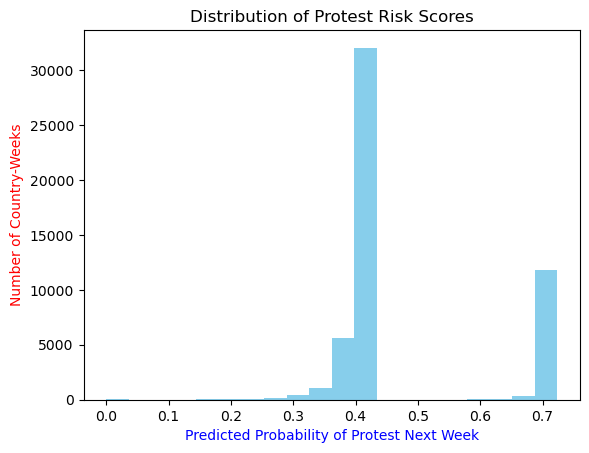

In [40]:
import matplotlib.pyplot as plt

# Histogram of risk scores
plt.hist(y_prob, bins=20, color='skyblue')
plt.xlabel("Predicted Probability of Protest Next Week", color='blue')
plt.ylabel("Number of Country-Weeks", color='red')
plt.title("Distribution of Protest Risk Scores")
plt.show()

In [44]:
#Save model
import joblib

joblib.dump(pipeline, "protest_prediction_model.pkl")

['protest_prediction_model.pkl']